# **Lab 3: การวิเคราะห์การเปลี่ยนแปลงพื้นที่สีเขียวโดยใช้ NDVI จากข้อมูลดาวเทียมหลายช่วงเวลาระหว่างปี 2020 และ 2025 กรณีพื้นที่ศึกษาจังหวัดเพชรบุรี**

In [166]:
!pip install geemap earthengine-api geopandas -q

In [167]:
import ee
import geemap
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [168]:
# Authenticate & Initialize Earth Engine
ee.Authenticate()
ee.Initialize(project='ee-khehathancencira')

## 1. การโหลดและเตรียมข้อมูล

In [169]:

#roi = ee.Geometry.Rectangle([99.3, 12.7, 100.1, 13.4])

In [170]:
# ขอบเขตจังหวัดทั่วโลก
adm1 = ee.FeatureCollection("FAO/GAUL/2015/level1")

phetchaburi = adm1.filter(
    ee.Filter.And(
        ee.Filter.eq('ADM0_NAME', 'Thailand'),
        ee.Filter.eq('ADM1_NAME', 'Phetchaburi')
    )
)

roi = phetchaburi.geometry()

In [171]:


Map = geemap.Map(center=[13.1, 99.8], zoom=8)
Map.addLayer(phetchaburi, {'color': 'red'}, 'Phetchaburi Province')
Map

Map(center=[13.1, 99.8], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(…

In [172]:
def load_s2(start_date, end_date):
    return (
        ee.ImageCollection("COPERNICUS/S2_SR")
        .filterBounds(roi)
        .filterDate(start_date, end_date)
        .select(["B4", "B8"])
        .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 20))
        .median()
        .clip(roi)
    )

In [173]:
# ปีปัจจุบัน
img_2025 = load_s2("2025-01-01", "2025-12-31")

# ปีก่อนหน้า
img_2020 = load_s2("2020-01-01", "2020-12-31")

## 2. การคำนวณ NDVI สำหรับแต่ละช่วงเวลา

In [174]:
ndvi_2025 = img_2025.normalizedDifference(["B8", "B4"]).rename("NDVI_2025")
ndvi_2020 = img_2020.normalizedDifference(["B8", "B4"]).rename("NDVI_2020")

In [175]:
def calculate_ndvi(image):
    ndvi = image.normalizedDifference(["B8", "B4"]).rename("NDVI")
    return ndvi

In [176]:
ndvi_2025 = calculate_ndvi(img_2025)
ndvi_2020 = calculate_ndvi(img_2020)

In [177]:
# แสดงแผนที่ NDVI
ndvi_vis = {
    "min": -1,
    "max": 1,
    "palette": ["darkred","red", "orange", "yellow", "green","darkgreen"]
}

Map = geemap.Map(center=[13.0, 99.7], zoom=9)
Map.addLayer(ndvi_2025, ndvi_vis, "NDVI 2025")
Map.addLayer(ndvi_2020, ndvi_vis, "NDVI 2020")
Map

Map(center=[13.0, 99.7], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(…

## 3. การวิเคราะห์ความเปลี่ยนแปลงของ NDVI (Change Detection)

In [178]:
delta_ndvi = ndvi_2025.subtract(ndvi_2020).rename("Delta_NDVI")

In [179]:
delta_vis = {
    "min": -0.5,
    "max": 0.5,
    "palette": ["red", "white", "green"]
}

Map = geemap.Map(center=[13.0, 99.7], zoom=9)
Map.addLayer(delta_ndvi, delta_vis, "ΔNDVI (2025-2020)")
Map

Map(center=[13.0, 99.7], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(…

**Threshold**

In [180]:
ndvi_loss = delta_ndvi.lt(-0.2)
ndvi_gain = delta_ndvi.gt(0.2)

Map = geemap.Map()
Map.centerObject(roi, 8)
Map.addLayer(ndvi_loss.selfMask(), {"palette": "red"}, "NDVI Loss")
Map.addLayer(ndvi_gain.selfMask(), {"palette": "green"}, "NDVI Gain")
Map

Map(center=[12.939334703711276, 99.62064625288545], controls=(WidgetControl(options=['position', 'transparent_…

**จุดตรวจวัด NDVI**

In [181]:
# จุดตรวจวัด NDVI ปี 2563
gdf_2020 = gpd.read_file("/content/LU_Pp_63.shp")

# จุดตรวจวัด NDVI ปี 2568
gdf_2025 = gpd.read_file("/content/LU_Pp_69.shp")

In [182]:
if gdf_2020.geometry.iloc[0].geom_type != "Point":
    gdf_2020["geometry"] = gdf_2020.geometry.centroid

if 'station' not in gdf_2020.columns:
    gdf_2020['station'] = gdf_2020.index.astype(str)

if gdf_2025.geometry.iloc[0].geom_type != "Point":
    gdf_2025["geometry"] = gdf_2025.geometry.centroid

if 'station' not in gdf_2025.columns:
    gdf_2025['station'] = gdf_2025.index.astype(str)

In [183]:
stations_2020 = geemap.geopandas_to_ee(gdf_2020)
stations_2025 = geemap.geopandas_to_ee(gdf_2025)

In [184]:
# To avoid the payload size error, sample a limited number of features if the collection is very large.
sampled_stations_2020 = stations_2020.limit(50) # Limit to 1000 features for visualization

Map = geemap.Map()
Map.centerObject(roi, 8)
Map.addLayer(ndvi_2020, {"min":-1,"max":1,"palette":["darkred","red", "orange", "yellow", "green","darkgreen"]}, "NDVI 2020")
Map.addLayer(sampled_stations_2020, {"color":"blue"}, "Stations 2020 (Sampled)") # Update layer name
Map

Map(center=[12.939334703711276, 99.62064625288545], controls=(WidgetControl(options=['position', 'transparent_…

In [185]:
sampled_stations_2025 = stations_2025.limit(50)

Map = geemap.Map()
Map.centerObject(roi, 8)
Map.addLayer(ndvi_2025, {"min":-1,"max":1,"palette":["darkred","red", "orange", "yellow", "green","darkgreen"]}, "NDVI 2568")
Map.addLayer(stations_2025, {"color":"red"}, "Stations 2025")
Map

Map(center=[12.939334703711276, 99.62064625288545], controls=(WidgetControl(options=['position', 'transparent_…

In [186]:
ndvi_station_2020 = ndvi_2020.sampleRegions(
    collection=stations_2020,
    scale=10,          # Sentinel-2 = 10 m
    geometries=True
)

ndvi_station_2025 = ndvi_2025.sampleRegions(
    collection=stations_2025,
    scale=10,
    geometries=True
)

In [187]:
def fc_to_df(fc, year):
    features = fc.getInfo()["features"]
    rows = []
    for f in features:
        props = f["properties"]
        props["year"] = year
        rows.append(props)
    return pd.DataFrame(rows)

In [188]:
df_stations.groupby(["year", "LU_DES_EN"])["NDVI"].mean()

year  LU_DES_EN             
2025  Abandoned orchard         0.407505
      Abandoned paddy field     0.429704
      Active paddy field        0.274753
      Banana                    0.369157
      Banana/Lime               0.444931
      Coconut                   0.454651
      Coconut/Banana            0.297081
      Dense deciduous forest    0.504794
      Dense mangrove  forest    0.008102
      Farm pond                 0.134927
      Fish farm                 0.320565
      Grass                     0.362307
      Lime                      0.393085
      Mango                     0.391334
      Marsh and Swamp           0.333913
      Mixed orchard             0.407282
      Mixed perennial           0.372588
      Oil palm                  0.405793
      Para rubber               0.448882
      Pineapple                 0.280109
      River, Canal              0.292849
      Shrubland                 0.365322
      Truck crop                0.264103
      Village                   0.318916
Name: NDVI, dtype: float64

In [189]:
import pandas as pd

df_2020 = fc_to_df(ndvi_station_2020, 2020)
df_2025 = fc_to_df(ndvi_station_2025, 2025)

df = df_2020.merge(df_2025, on="station", suffixes=('_2020', '_2025'))
df["Delta_NDVI"] = df["NDVI_2025"] - df["NDVI_2020"]
df

,CID_2020,FID_LU_202_2020,FID_LU_P_6_2020,NDVI_2020,ORIG_FID_2020,amphoe_t,lu_code,lu_des_th,lu_type,prov_nam_t,...,LU_DES_TH,LU_ID_L1,LU_ID_L2,LU_ID_L3,NDVI_2025,ORIG_FID_2025,year_2025,LU_DES,LU_DES68,Delta_NDVI
0,45303,45303,32,0.457119,45303,อ.ชะอำ,A205,สับปะรด,A2,จ.เพชรบุรี,...,มะพร้าว/กล้วย,2,24,240512411,0.297081,23751,2025,NaN,NaN,-0.160038
1,24206,24206,17,0.137972,24206,อ.ชะอำ,W202,บ่อน้ำในไร่นา,W,จ.เพชรบุรี,...,ปาล์มน้ำมัน,2,23,2303,0.438720,12234,2025,P1,P1,0.300748
2,63350,63350,45,0.490748,63350,อ.ชะอำ,U201,หมู่บ้านบนพื้นราบ,U,จ.เพชรบุรี,...,ไม้ยืนต้นผสม,2,23,2301,0.372588,10348,2025,NaN,NaN,-0.118160
3,1130,1130,3,0.284611,1130,อ.ชะอำ,A203,อ้อย,A2,จ.เพชรบุรี,...,กล้วย,2,24,2411,0.406285,25641,2025,NaN,NaN,0.121674
4,22041,22041,16,0.365327,22041,อ.ชะอำ,U201,หมู่บ้านบนพื้นราบ,U,จ.เพชรบุรี,...,ทุ่งหญ้าธรรมชาติ,5,51,5101,0.395765,41123,2025,NaN,NaN,0.030438
5,49887,49887,36,0.143447,49887,อ.ชะอำ,W202,บ่อน้ำในไร่นา,W,จ.เพชรบุรี,...,ทุ่งหญ้าสลับไม้พุ่ม/ไม้ละเมาะ,5,51,5102,0.323285,43667,2025,NaN,NaN,0.179838
6,179,179,1,0.360812,179,อ.ชะอำ,A405/A411,มะพร้าว/กล้วย,A4,จ.เพชรบุรี,...,ป่าผลัดใบสมบูรณ์,3,32,3201,0.504794,40421,2025,NaN,NaN,0.143982
7,9202,9202,8,0.260795,9202,อ.ท่ายาง,M101,ทุ่งหญ้าธรรมชาติ,M,จ.เพชรบุรี,...,มะม่วง,2,24,2407,0.391334,24057,2025,NaN,NaN,0.130539
8,59302,59302,43,0.307987,59302,อ.แก่งกระจาน,A426,แก้วมังกร,A4,จ.เพชรบุรี,...,แม่น้ำ ลำห้วย ลำคลอง,4,41,4101,0.292849,62800,2025,NaN,NaN,-0.015138
9,59700,59700,44,0.375893,59700,อ.ท่ายาง,A502,พืชผัก,A5,จ.เพชรบุรี,...,สับปะรด,2,22,2205,0.280109,7797,2025,NaN,NaN,-0.095784


## 4. การวิเคราะห์ความสัมพันธ์ของ NDVI กับภูมิประเทศ



*   ใช้ DEM
*   ดึงค่า NDVI และ DEM ที่ตำแหน่งเดียวกัน
*   วิเคราะห์เชิงสถิติ / กราฟ



In [ ]:
# โหลด DEM
dem = ee.Image("USGS/SRTMGL1_003").clip(roi)
dem

In [191]:
Map = geemap.Map()
Map.centerObject(roi, 8)
Map.addLayer(dem, {"min": 0, "max": 1500}, "DEM")
Map

Map(center=[12.939334703711276, 99.62064625288545], controls=(WidgetControl(options=['position', 'transparent_…

In [192]:
# รวม NDVI และ DEM
stack = ndvi_2025.addBands(dem.rename("DEM"))

In [193]:
samples = stack.sample(
    region=roi,
    scale=30,          # ให้สอดคล้องกับ DEM
    numPixels=5000,    # เพิ่มจำนวนจุดตัวอย่างเพื่อเพิ่มโอกาสในการสุ่มได้ข้อมูล
    geometries=False
)

# ตรวจสอบจำนวนจุดตัวอย่างที่ได้
print(f"Number of sampled pixels: {samples.size().getInfo()}")

Number of sampled pixels: 5000


In [194]:
 # แปลงเป็น numpy
data = samples.reduceColumns(
    ee.Reducer.toList(2),
    ["NDVI", "DEM"]
).get("list")

data = np.array(data.getInfo())
ndvi_vals = data[:, 0]
dem_vals = data[:, 1]

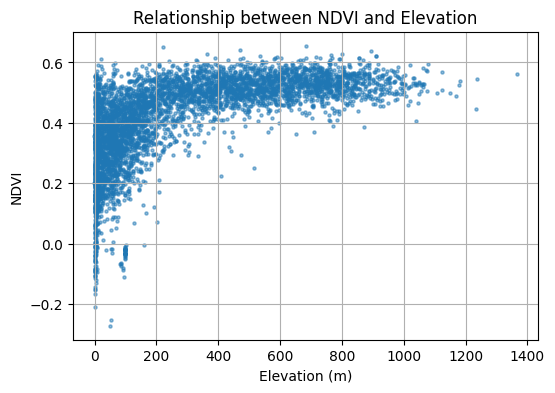

In [195]:
# Scatter plot NDVI vs DEM
plt.figure(figsize=(6,4))
plt.scatter(dem_vals, ndvi_vals, s=5, alpha=0.5)
plt.xlabel("Elevation (m)")
plt.ylabel("NDVI")
plt.title("Relationship between NDVI and Elevation")
plt.grid(True)
plt.show()

## สรุปผลเชิงสถิติ

In [196]:
# Sample ΔNDVI
delta_sample = delta_ndvi.sample(
    region=roi,
    scale=30,
    numPixels=5000,
    geometries=False
)

values = delta_sample.aggregate_array("Delta_NDVI").getInfo()

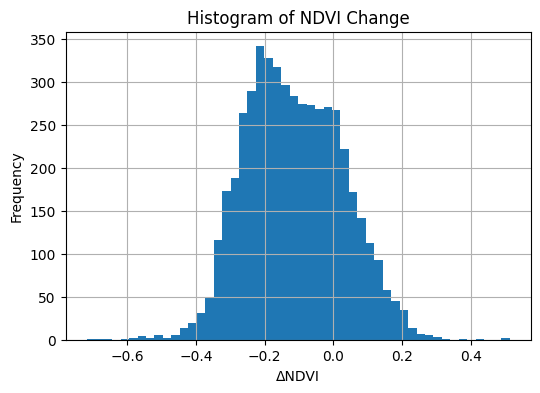

In [197]:
plt.figure(figsize=(6,4))
plt.hist(values, bins=50)
plt.xlabel("ΔNDVI")
plt.ylabel("Frequency")
plt.title("Histogram of NDVI Change")
plt.grid(True)
plt.show()

### 5. คำถามท้าย Lab

1.	ทำไมการวิเคราะห์ NDVI จากภาพถ่ายดาวเทียมหลายช่วงเวลาจึงมีความสำคัญ?

คำตอบ :
เพื่อดูการเปลี่ยนแปลงเชิงพื้นที่ เช่น ป่าไม้ ประเภทการใช้ที่ดิน สุขภาพของพืช

2.	พื้นที่ที่มีการเปลี่ยนแปลง NDVI อย่างมีนัยสำคัญควรได้รับการตรวจสอบเพิ่มเติมอย่างไร?

คำตอบ : ควรลงพื้นที่ตรวจสอบว่ากิจกรรมใดเกิดขึ้น กิจกรรมมีสาเหตุจากอะไร และส่งผลกระทบต่อพื้นที่อย่างไร

3.	ปัจจัยใดที่อาจทำให้ค่า NDVI เปลี่ยนแปลงโดยไม่เกี่ยวข้องกับการเปลี่ยนแปลงของพืชพรรณ?

คำตอบ : ถูกรบกวนโดย ชั้นบรรญากาศ เช่น เมฆ ฝุ่น และ ความผิดพลาดจากตัวเซนเซอร์

4.	หากต้องการเพิ่มความแม่นยำของการวิเคราะห์การเปลี่ยนแปลง NDVI ควรใช้เทคนิคอะไรเพิ่มเติม?

คำตอบ : การใช้ภาพถ่ายดาวเทียมความละเอียดสูงเทคนิคการแก้ไขผลกระทบจากบรรยากาศ ,การคำนวณดัชนีพืชพรรณอื่นร่วมด้วย เช่น EVI, NDWI เพื่อลดความอิ่มตัว และใช้เทคนิควิเคราะห์เชิงเวลา

5.	ทำไมการใช้ DEM จึงช่วยให้เข้าใจบริบทของ NDVI ได้ดีขึ้น?

คำตอบ : การใช้ DEM ร่วมกับ NDVI ช่วยให้เข้าใจบริบทของความสมบูรณ์พืชพรรณได้ดีขึ้น โดยการเพิ่มมิติความสูง Slope และAspect ซึ่งส่งผลต่อการเติบโตของพืชที่แตกต่างกัน จากการวิเคราะห์ใน จังหวัดเพชรบุรี พบว่า ความสูงกับ NDVI มีความแปรผันกัน ทำให้สามารถวิเคราะห์สาเหตุของ NDVI สูง มีความสูงระดับ ปานกลางถึงสูงมา เนื่องจากถูกรบกวนน้อย เช่น พื้นที่ป่าแก่งกระจาน ดูแลโดยเจ้าหน้าที่ ขณะที่ พื้นที่ราบ เป็นที่อยู่อาศัย มีการขยายเมืองทำให้มีค่า NDVI ต่ำ

**แหล่งข้อมูล**
1. ประเภทการใช้ประโยชน์ที่ดิน ปี 2563 จากกรมพัฒนาที่ดิน : https://soilwarehouse.ldd.go.th/frm_mapmain.aspx
2. ประเภทการใช้ประโยชน์ที่ดิน 2568 จากกรมพัฒนาที่ดิน  :  https://lddcatalog.ldd.go.th/dataset/ldd_21_01
3. ภาพถ่ายจากดาวเทียม sentinel 2 จาก COPERNICUS : COPERNICUS/S2_SR (Sentinel-2 Level 2A Surface Reflectance)https://documentation.dataspace.copernicus.eu/Data/SentinelMissions/Sentinel2.html
4. ข้อมูล DEM จาก USGS : USGS/SRTMGL1_003 (NASA Shuttle Radar Topography Mission Global 1 arc second V003)